In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fastf1 as ff1

ff1.Cache.enable_cache('cache')

In [12]:
import warnings
warnings.filterwarnings('ignore')
# ignore info messages
import logging
logging.getLogger('fastf1').setLevel(logging.WARNING)

In [13]:
def get_empty_dataframe():
    return pd.DataFrame(
            columns=[
                'LapStartTime',
                'LapNumber',
                'LapTime',
                'DriverNumber',
                'Compound',
                'TyreLife',
                'TrackStatus',
                'Stint',
                'DistanceToDriverAhead',
                'DriverAhead',
                'PitStatus',
                'IsAccurate',
                ])

In [24]:
# Exception that is raised when there is no telemetry data for a given lap.
class NoTelemetryException(Exception):
    pass

# Find the telemetry data (Driver Ahead, Distance to Driver Ahead) for the start of a lap and merge it with the lap data.
def get_telemetry_at_start_of_lap(lap, telemetry):
    # Find the telemetry data for the start of the lap by creating a 1 second window around the lap start time.
    mask = (telemetry['Date'] > lap['LapStartDate']) & (telemetry['Date'] <= lap['LapStartDate'] + pd.Timedelta(seconds=1))
    rows = telemetry.loc[mask]
    # If there is no telemetry data for the lap, raise an exception.
    if rows.empty:
        raise NoTelemetryException("No telemetry data found for lap " + str(lap['LapNumber']) + " of " + str(lap['Driver']) + " at " + str(lap['LapStartDate']))
    row = rows.iloc[0] # There can be multiple telemetry samples in the 1 second window, so take the first one.
    telemetryInfo = row[['DriverAhead', 'DistanceToDriverAhead']] # Get the telemetry data we are interested in.
    lapInfo = lap[['LapStartTime', 'LapNumber', 'LapTime', 'DriverNumber', 'Compound', 'TyreLife', 'Stint', 'TrackStatus', 'IsAccurate']] # Get the lap data we are interested in.
    lap['PitOutTime'] = lap['PitOutTime'].total_seconds() if lap['PitOutTime'] is not None else 0 # Convert the pit out time to seconds.
    lap['PitInTime'] = lap['PitInTime'].total_seconds() if lap['PitInTime'] is not None else 0 # Convert the pit in time to seconds.
    lapInfo['PitStatus'] = 'OutLap' if lap['PitOutTime'] > 0 else 'InLap' if lap['PitInTime'] > 0 else 'NoPit' # Get the pit status.
    telemetryInfo.rename("Telemetry", inplace=True)
    lapInfo.rename("Lap", inplace=True)
    merge = pd.concat([telemetryInfo, lapInfo]) # Merge the telemetry and lap data.
    return merge


In [15]:
# Exception that is raised when there is no data for a given lap.
class NoLapException(Exception):
    pass

# Find all the laps for a given driver and merge the telemetry data for the start of each lap.
def get_laps_of_driver(driver, laps):
    driver_laps = laps.pick_driver(driver)
    if len(driver_laps['DriverNumber']) == 0:
        raise NoLapException("No laps for driver " + driver)
    driver_laps_telemetry = driver_laps.get_car_data()
    if len(driver_laps_telemetry) == 0:
        raise NoLapException("No telemetry for driver " + driver)
    try:
        driver_laps_telemetry = driver_laps_telemetry.add_driver_ahead()
        transformed_laps = []
        for index, row in driver_laps.iterrows():
            try:
                transformed_laps.append(get_telemetry_at_start_of_lap(row, driver_laps_telemetry))
            except NoTelemetryException as e:
                print(e)
    except ValueError as e:
        print("error : ", e)
        print(driver_laps_telemetry)
        return get_empty_dataframe()
    return pd.DataFrame(transformed_laps)

# Add weather data that would have been available at the start of each lap.
def add_weather_to_laps(laps, weather):
    if laps.empty:
        raise NoLapException("Laps dataframe is empty")
    # Effectuer une jointure basée sur une plage de temps
    lapsWithWeather = pd.merge_asof(laps.sort_values('LapStartTime'), 
                                    weather.sort_values('Time'), 
                                    left_on='LapStartTime', 
                                    right_on='Time', 
                                    by=None, 
                                    direction='backward')

    return lapsWithWeather

In [16]:
import os

# Get the data for all the races within a given year and save it to csv files.
def get_season_data(year, save_all_races=True):
    schedule = ff1.get_event_schedule(year, include_testing=False)
    
    path = 'data/' + str(year)
    # Create a directory for the year if it doesn't exist
    if not os.path.exists(path):
        os.makedirs(path)

    df_season = get_empty_dataframe()
    for index, event in schedule.iterrows():
        if year == 2018 and event['RoundNumber'] < 3: # The 2 first races of 2018 do not have telemetry data
            continue
        print("Processing race round - ", event['RoundNumber'])
        race = event.get_race()
        race.load()
        df_event = get_empty_dataframe()
        for driver in race.drivers:
            print("     Processing driver - ", driver)
            try:
                df_event = pd.concat([df_event, get_laps_of_driver(driver, race.laps)], axis=0)
            except NoLapException as e:
                print(e)
    
        df_event['Track'] = event['Location']
        try:
            df_event = add_weather_to_laps(df_event, race.weather_data)
            df_event = df_event.drop(columns=['Time'])
            # Convert the laptime column to total seconds if it's not a NAN value
            df_event['LapTime'] = df_event['LapTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)
            df_event['LapStartTime'] = df_event['LapStartTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)
        except NoLapException as e:
            print(e)
        if save_all_races:
            # Save it to a csv file
            df_event.to_csv(path + '/' + event.EventName.replace(' ', '_').lower() + '.csv', index=False)
        df_season = pd.concat([df_season, df_event], axis=0)

    # Save the data for the whole season
    df_season.to_csv(path + '/season.csv', index=False)
    return df_season

In [26]:
for year in range(2018, 2023):
    get_season_data(year)

core           INFO 	Loading data for Chinese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data


Processing race round -  3


api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '77', '7', '44', '33', '27', '14', '5', '55', '20', '31', '11', '2', '18', '35', '9', '8', '10', '16', '28']


     Processing driver -  3
     Processing driver -  77
     Processing driver -  7
     Processing driver -  44
     Processing driver -  33
     Processing driver -  27
     Processing driver -  14
     Processing driver -  5
     Processing driver -  55
     Processing driver -  20
     Processing driver -  31
     Processing driver -  11
     Processing driver -  2
     Processing driver -  18
     Processing driver -  35
     Processing driver -  9
     Processing driver -  8
     Processing driver -  10
     Processing driver -  16
     Processing driver -  28


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data


Processing race round -  4


core        WARNING 	Driver 55: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '7', '11', '5', '55', '16', '14', '18', '2', '28', '9', '10', '20', '77', '8', '33', '3', '27', '31', '35']


     Processing driver -  44
     Processing driver -  7
     Processing driver -  11
     Processing driver -  5
     Processing driver -  55
     Processing driver -  16
     Processing driver -  14
     Processing driver -  18
     Processing driver -  2
     Processing driver -  28
     Processing driver -  9
     Processing driver -  10
     Processing driver -  20
     Processing driver -  77
     Processing driver -  8
     Processing driver -  33
     Processing driver -  3
     Processing driver -  27
     Processing driver -  31
     Processing driver -  35


core           INFO 	Loading data for Spanish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data


Processing race round -  5


api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '3', '20', '55', '14', '11', '16', '18', '28', '9', '35', '2', '31', '7', '8', '10', '27']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  33
     Processing driver -  5
     Processing driver -  3
     Processing driver -  20
     Processing driver -  55
     Processing driver -  14
     Processing driver -  11
     Processing driver -  16
     Processing driver -  18
     Processing driver -  28
     Processing driver -  9
     Processing driver -  35
     Processing driver -  2
     Processing driver -  31
     Processing driver -  7
     Processing driver -  8
     Processing driver -  10
     Processing driver -  27


core           INFO 	Loading data for Monaco Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  6


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '5', '44', '7', '77', '31', '10', '27', '33', '55', '9', '11', '20', '2', '8', '35', '18', '16', '28', '14']


     Processing driver -  3
     Processing driver -  5
     Processing driver -  44
     Processing driver -  7
     Processing driver -  77
     Processing driver -  31
     Processing driver -  10
     Processing driver -  27
     Processing driver -  33
     Processing driver -  55
     Processing driver -  9
     Processing driver -  11
     Processing driver -  20
     Processing driver -  2
     Processing driver -  8
     Processing driver -  35
     Processing driver -  18
     Processing driver -  16
     Processing driver -  28
     Processing driver -  14


core           INFO 	Loading data for Canadian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  7


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '77', '33', '3', '44', '7', '27', '55', '31', '16', '10', '8', '20', '11', '9', '2', '35', '14', '28', '18']


     Processing driver -  5
     Processing driver -  77
     Processing driver -  33
     Processing driver -  3
     Processing driver -  44
     Processing driver -  7
     Processing driver -  27
     Processing driver -  55
     Processing driver -  31
     Processing driver -  16
     Processing driver -  10
     Processing driver -  8
     Processing driver -  20
     Processing driver -  11
     Processing driver -  9
     Processing driver -  2
     Processing driver -  35
     Processing driver -  14
     Processing driver -  28
     Processing driver -  18


core           INFO 	Loading data for French Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  8


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '7', '3', '5', '20', '77', '55', '27', '16', '8', '2', '9', '28', '35', '14', '18', '11', '31', '10']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  7
     Processing driver -  3
     Processing driver -  5
     Processing driver -  20
     Processing driver -  77
     Processing driver -  55
     Processing driver -  27
     Processing driver -  16
     Processing driver -  8
     Processing driver -  2
     Processing driver -  9
     Processing driver -  28
     Processing driver -  35
     Processing driver -  14
     Processing driver -  18
     Processing driver -  11
     Processing driver -  31
     Processing driver -  10


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  9


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '7', '5', '8', '20', '31', '11', '14', '16', '9', '10', '55', '35', '18', '2', '44', '28', '3', '77', '27']


     Processing driver -  33
     Processing driver -  7
     Processing driver -  5
     Processing driver -  8
     Processing driver -  20
     Processing driver -  31
     Processing driver -  11
     Processing driver -  14
     Processing driver -  16
     Processing driver -  9
     Processing driver -  10
     Processing driver -  55
     Processing driver -  35
     Processing driver -  18
     Processing driver -  2
     Processing driver -  44
     Processing driver -  28
     Processing driver -  3
     Processing driver -  77
     Processing driver -  27


core           INFO 	Loading data for British Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  10


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver  2: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '7', '77', '3', '27', '31', '14', '20', '11', '2', '18', '10', '35', '33', '8', '55', '9', '16', '28']


     Processing driver -  5
     Processing driver -  44
     Processing driver -  7
     Processing driver -  77
     Processing driver -  3
     Processing driver -  27
     Processing driver -  31
     Processing driver -  14
     Processing driver -  20
     Processing driver -  11
     Processing driver -  2
     Processing driver -  18
     Processing driver -  10
     Processing driver -  35
     Processing driver -  33
     Processing driver -  8
     Processing driver -  55
     Processing driver -  9
     Processing driver -  16
     Processing driver -  28


core           INFO 	Loading data for German Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  11


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '7', '33', '27', '8', '11', '31', '9', '28', '20', '55', '2', '10', '16', '14', '18', '5', '35', '3']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  7
     Processing driver -  33
     Processing driver -  27
     Processing driver -  8
     Processing driver -  11
     Processing driver -  31
     Processing driver -  9
     Processing driver -  28
     Processing driver -  20
     Processing driver -  55
     Processing driver -  2
     Processing driver -  10
     Processing driver -  16
     Processing driver -  14
     Processing driver -  18
     Processing driver -  5
     Processing driver -  35
     Processing driver -  3


core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  12


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '7', '3', '77', '10', '20', '14', '55', '8', '28', '27', '31', '11', '9', '35', '18', '2', '33', '16']


     Processing driver -  44
     Processing driver -  5
     Processing driver -  7
     Processing driver -  3
     Processing driver -  77
     Processing driver -  10
     Processing driver -  20
     Processing driver -  14
     Processing driver -  55
     Processing driver -  8
     Processing driver -  28
     Processing driver -  27
     Processing driver -  31
     Processing driver -  11
     Processing driver -  9
     Processing driver -  35
     Processing driver -  18
     Processing driver -  2
     Processing driver -  33
     Processing driver -  16


core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  13


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '44', '33', '77', '11', '31', '8', '20', '10', '9', '55', '35', '18', '28', '2', '3', '7', '16', '14', '27']


     Processing driver -  5
     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  11
     Processing driver -  31
     Processing driver -  8
     Processing driver -  20
     Processing driver -  10
     Processing driver -  9
     Processing driver -  55
     Processing driver -  35
     Processing driver -  18
     Processing driver -  28
     Processing driver -  2
     Processing driver -  3
     Processing driver -  7
     Processing driver -  16
     Processing driver -  14
     Processing driver -  27


core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  14


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '7', '77', '5', '33', '31', '11', '55', '18', '35', '16', '2', '27', '10', '9', '20', '3', '14', '28', '8']


     Processing driver -  44
     Processing driver -  7
     Processing driver -  77
     Processing driver -  5
     Processing driver -  33
     Processing driver -  31
     Processing driver -  11
     Processing driver -  55
     Processing driver -  18
     Processing driver -  35
     Processing driver -  16
     Processing driver -  2
     Processing driver -  27
     Processing driver -  10
     Processing driver -  9
     Processing driver -  20
     Processing driver -  3
     Processing driver -  14
     Processing driver -  28
     Processing driver -  8


core           INFO 	Loading data for Singapore Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  15


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '77', '7', '3', '14', '55', '16', '27', '9', '2', '10', '18', '8', '11', '28', '20', '35', '31']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  5
     Processing driver -  77
     Processing driver -  7
     Processing driver -  3
     Processing driver -  14
     Processing driver -  55
     Processing driver -  16
     Processing driver -  27
     Processing driver -  9
     Processing driver -  2
     Processing driver -  10
     Processing driver -  18
     Processing driver -  8
     Processing driver -  11
     Processing driver -  28
     Processing driver -  20
     Processing driver -  35
     Processing driver -  31


core           INFO 	Loading data for Russian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  16


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '7', '33', '3', '16', '20', '31', '11', '8', '27', '9', '14', '18', '2', '55', '35', '10', '28']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  5
     Processing driver -  7
     Processing driver -  33
     Processing driver -  3
     Processing driver -  16
     Processing driver -  20
     Processing driver -  31
     Processing driver -  11
     Processing driver -  8
     Processing driver -  27
     Processing driver -  9
     Processing driver -  14
     Processing driver -  18
     Processing driver -  2
     Processing driver -  55
     Processing driver -  35
     Processing driver -  10
     Processing driver -  28


core           INFO 	Loading data for Japanese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  17


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '7', '5', '11', '8', '31', '55', '10', '9', '28', '14', '2', '35', '18', '16', '27', '20']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  33
     Processing driver -  3
     Processing driver -  7
     Processing driver -  5
     Processing driver -  11
     Processing driver -  8
     Processing driver -  31
     Processing driver -  55
     Processing driver -  10
     Processing driver -  9
     Processing driver -  28
     Processing driver -  14
     Processing driver -  2
     Processing driver -  35
     Processing driver -  18
     Processing driver -  16
     Processing driver -  27
     Processing driver -  20


core           INFO 	Loading data for United States Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  18


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['7', '33', '44', '5', '77', '27', '55', '11', '28', '9', '2', '10', '35', '18', '16', '3', '8', '14', '31', '20']


     Processing driver -  7
     Processing driver -  33
     Processing driver -  44
     Processing driver -  5
     Processing driver -  77
     Processing driver -  27
     Processing driver -  55
     Processing driver -  11
     Processing driver -  28
     Processing driver -  9
     Processing driver -  2
     Processing driver -  10
     Processing driver -  35
     Processing driver -  18
     Processing driver -  16
     Processing driver -  3
     Processing driver -  8
     Processing driver -  14
     Processing driver -  31
     Processing driver -  20


core           INFO 	Loading data for Mexican Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  19


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '7', '44', '77', '27', '16', '2', '9', '10', '31', '18', '35', '28', '20', '8', '3', '11', '55', '14']


     Processing driver -  33
     Processing driver -  5
     Processing driver -  7
     Processing driver -  44
     Processing driver -  77
     Processing driver -  27
     Processing driver -  16
     Processing driver -  2
     Processing driver -  9
     Processing driver -  10
     Processing driver -  31
     Processing driver -  18
     Processing driver -  35
     Processing driver -  28
     Processing driver -  20
     Processing driver -  8
     Processing driver -  3
     Processing driver -  11
     Processing driver -  55
     Processing driver -  14


core           INFO 	Loading data for Brazilian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  20


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '7', '3', '77', '5', '16', '8', '20', '11', '28', '55', '10', '2', '31', '35', '14', '18', '27', '9']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  7
     Processing driver -  3
     Processing driver -  77
     Processing driver -  5
     Processing driver -  16
     Processing driver -  8
     Processing driver -  20
     Processing driver -  11
     Processing driver -  28
     Processing driver -  55
     Processing driver -  10
     Processing driver -  2
     Processing driver -  31
     Processing driver -  35
     Processing driver -  14
     Processing driver -  18
     Processing driver -  27
     Processing driver -  9


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  21


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '33', '3', '77', '55', '16', '11', '8', '20', '14', '28', '18', '2', '35', '10', '31', '9', '7', '27']


     Processing driver -  44
     Processing driver -  5
     Processing driver -  33
     Processing driver -  3
     Processing driver -  77
     Processing driver -  55
     Processing driver -  16
     Processing driver -  11
     Processing driver -  8
     Processing driver -  20
     Processing driver -  14
     Processing driver -  28
     Processing driver -  18
     Processing driver -  2
     Processing driver -  35
     Processing driver -  10
     Processing driver -  31
     Processing driver -  9
     Processing driver -  7
     Processing driver -  27


core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  1


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '5', '16', '20', '27', '7', '18', '26', '10', '4', '11', '23', '99', '63', '88', '8', '3', '55']


     Processing driver -  77
     Processing driver -  44
     Processing driver -  33
     Processing driver -  5
     Processing driver -  16
     Processing driver -  20
     Processing driver -  27
     Processing driver -  7
     Processing driver -  18
     Processing driver -  26
     Processing driver -  10
     Processing driver -  4
     Processing driver -  11
     Processing driver -  23
     Processing driver -  99
     Processing driver -  63
     Processing driver -  88
     Processing driver -  8
     Processing driver -  3
     Processing driver -  55


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  2


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '4', '7', '10', '23', '11', '99', '26', '20', '18', '63', '88', '27', '3', '55', '8']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  16
     Processing driver -  33
     Processing driver -  5
     Processing driver -  4
     Processing driver -  7
     Processing driver -  10
     Processing driver -  23
     Processing driver -  11
     Processing driver -  99
     Processing driver -  26
     Processing driver -  20
     Processing driver -  18
     Processing driver -  63
     Processing driver -  88
     Processing driver -  27
     Processing driver -  3
     Processing driver -  55
     Processing driver -  8


core           INFO 	Loading data for Chinese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  3


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '5', '33', '16', '10', '3', '11', '7', '23', '8', '18', '20', '55', '99', '63', '88', '4', '26', '27']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  5
     Processing driver -  33
     Processing driver -  16
     Processing driver -  10
     Processing driver -  3
     Processing driver -  11
     Processing driver -  7
     Processing driver -  23
     Processing driver -  8
     Processing driver -  18
     Processing driver -  20
     Processing driver -  55
     Processing driver -  99
     Processing driver -  63
     Processing driver -  88
     Processing driver -  4
     Processing driver -  26
     Processing driver -  27


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  4


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '5', '33', '16', '11', '55', '4', '18', '7', '23', '99', '20', '27', '63', '88', '10', '8', '26', '3']


     Processing driver -  77
     Processing driver -  44
     Processing driver -  5
     Processing driver -  33
     Processing driver -  16
     Processing driver -  11
     Processing driver -  55
     Processing driver -  4
     Processing driver -  18
     Processing driver -  7
     Processing driver -  23
     Processing driver -  99
     Processing driver -  20
     Processing driver -  27
     Processing driver -  63
     Processing driver -  88
     Processing driver -  10
     Processing driver -  8
     Processing driver -  26
     Processing driver -  3


core           INFO 	Loading data for Spanish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  5


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '5', '16', '10', '20', '55', '26', '8', '23', '3', '27', '7', '11', '99', '63', '88', '18', '4']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  33
     Processing driver -  5
     Processing driver -  16
     Processing driver -  10
     Processing driver -  20
     Processing driver -  55
     Processing driver -  26
     Processing driver -  8
     Processing driver -  23
     Processing driver -  3
     Processing driver -  27
     Processing driver -  7
     Processing driver -  11
     Processing driver -  99
     Processing driver -  63
     Processing driver -  88
     Processing driver -  18
     Processing driver -  4


core           INFO 	Loading data for Monaco Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  6


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '33', '10', '55', '26', '23', '3', '8', '4', '11', '27', '20', '63', '18', '7', '88', '99', '16']


     Processing driver -  44
     Processing driver -  5
     Processing driver -  77
     Processing driver -  33
     Processing driver -  10
     Processing driver -  55
     Processing driver -  26
     Processing driver -  23
     Processing driver -  3
     Processing driver -  8
     Processing driver -  4
     Processing driver -  11
     Processing driver -  27
     Processing driver -  20
     Processing driver -  63
     Processing driver -  18
     Processing driver -  7
     Processing driver -  88
     Processing driver -  99
     Processing driver -  16


core           INFO 	Loading data for Canadian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  7


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '16', '77', '33', '3', '27', '10', '18', '26', '55', '11', '99', '8', '7', '63', '20', '88', '23', '4']


     Processing driver -  44
     Processing driver -  5
     Processing driver -  16
     Processing driver -  77
No telemetry data found for lap 18 of BOT at 2019-06-09 18:35:17.031000
     Processing driver -  33
No telemetry data found for lap 18 of VER at 2019-06-09 18:35:17.681000
     Processing driver -  3
     Processing driver -  27
     Processing driver -  10
     Processing driver -  18
     Processing driver -  26
     Processing driver -  55
     Processing driver -  11
     Processing driver -  99
     Processing driver -  8
     Processing driver -  7
     Processing driver -  63
     Processing driver -  20
     Processing driver -  88
     Processing driver -  23
     Processing driver -  4


core           INFO 	Loading data for French Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  8


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '5', '55', '7', '27', '4', '10', '3', '11', '18', '26', '23', '99', '20', '88', '63', '8']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  16
     Processing driver -  33
     Processing driver -  5
     Processing driver -  55
     Processing driver -  7
     Processing driver -  27
     Processing driver -  4
     Processing driver -  10
     Processing driver -  3
     Processing driver -  11
     Processing driver -  18
     Processing driver -  26
     Processing driver -  23
     Processing driver -  99
     Processing driver -  20
     Processing driver -  88
     Processing driver -  63
     Processing driver -  8


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  9


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '16', '77', '5', '44', '4', '10', '55', '7', '99', '11', '3', '27', '18', '23', '8', '26', '63', '20', '88']


     Processing driver -  33
     Processing driver -  16
     Processing driver -  77
     Processing driver -  5
     Processing driver -  44
     Processing driver -  4
     Processing driver -  10
     Processing driver -  55
     Processing driver -  7
     Processing driver -  99
     Processing driver -  11
     Processing driver -  3
     Processing driver -  27
     Processing driver -  18
     Processing driver -  23
     Processing driver -  8
     Processing driver -  26
     Processing driver -  63
     Processing driver -  20
     Processing driver -  88


core           INFO 	Loading data for British Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  10


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '10', '33', '55', '3', '7', '26', '27', '4', '23', '18', '63', '88', '5', '11', '99', '8', '20']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  16
     Processing driver -  10
     Processing driver -  33
     Processing driver -  55
     Processing driver -  3
     Processing driver -  7
     Processing driver -  26
     Processing driver -  27
     Processing driver -  4
     Processing driver -  23
     Processing driver -  18
     Processing driver -  63
     Processing driver -  88
     Processing driver -  5
     Processing driver -  11
     Processing driver -  99
     Processing driver -  8
     Processing driver -  20


core           INFO 	Loading data for German Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  11


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '5', '26', '18', '55', '23', '8', '20', '44', '88', '63', '7', '99', '10', '77', '27', '16', '4', '3', '11']


     Processing driver -  33
     Processing driver -  5
     Processing driver -  26
     Processing driver -  18
     Processing driver -  55
     Processing driver -  23
     Processing driver -  8
     Processing driver -  20
     Processing driver -  44
     Processing driver -  88
     Processing driver -  63
     Processing driver -  7
     Processing driver -  99
     Processing driver -  10
     Processing driver -  77
     Processing driver -  27
     Processing driver -  16
     Processing driver -  4
     Processing driver -  3
     Processing driver -  11


core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  12


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '5', '16', '55', '10', '7', '77', '4', '23', '11', '27', '20', '3', '26', '63', '18', '99', '88', '8']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  5
     Processing driver -  16
     Processing driver -  55
     Processing driver -  10
     Processing driver -  7
     Processing driver -  77
     Processing driver -  4
     Processing driver -  23
     Processing driver -  11
     Processing driver -  27
     Processing driver -  20
     Processing driver -  3
     Processing driver -  26
     Processing driver -  63
     Processing driver -  18
     Processing driver -  99
     Processing driver -  88
     Processing driver -  8


core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  13


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '44', '77', '5', '23', '11', '26', '27', '10', '18', '4', '20', '8', '3', '63', '7', '88', '99', '55', '33']


     Processing driver -  16
     Processing driver -  44
     Processing driver -  77
     Processing driver -  5
     Processing driver -  23
     Processing driver -  11
     Processing driver -  26
     Processing driver -  27
     Processing driver -  10
     Processing driver -  18
     Processing driver -  4
     Processing driver -  20
     Processing driver -  8
     Processing driver -  3
     Processing driver -  63
     Processing driver -  7
     Processing driver -  88
     Processing driver -  99
     Processing driver -  55
     Processing driver -  33


core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  14


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '77', '44', '3', '27', '23', '11', '33', '99', '4', '10', '18', '5', '63', '7', '8', '88', '20', '26', '55']


     Processing driver -  16
     Processing driver -  77
     Processing driver -  44
     Processing driver -  3
     Processing driver -  27
     Processing driver -  23
     Processing driver -  11
     Processing driver -  33
     Processing driver -  99
     Processing driver -  4
     Processing driver -  10
     Processing driver -  18
     Processing driver -  5
     Processing driver -  63
     Processing driver -  7
     Processing driver -  8
     Processing driver -  88
     Processing driver -  20
     Processing driver -  26
     Processing driver -  55


core           INFO 	Loading data for Singapore Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  15


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['5', '16', '33', '44', '77', '23', '4', '10', '27', '99', '8', '55', '18', '3', '26', '88', '20', '7', '11', '63']


     Processing driver -  5
     Processing driver -  16
     Processing driver -  33
     Processing driver -  44
     Processing driver -  77
     Processing driver -  23
     Processing driver -  4
     Processing driver -  10
     Processing driver -  27
     Processing driver -  99
     Processing driver -  8
     Processing driver -  55
     Processing driver -  18
     Processing driver -  3
     Processing driver -  26
     Processing driver -  88
     Processing driver -  20
     Processing driver -  7
     Processing driver -  11
     Processing driver -  63


core           INFO 	Loading data for Russian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  16


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '16', '33', '23', '55', '11', '4', '20', '27', '18', '26', '7', '10', '99', '88', '63', '5', '3', '8']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  16
     Processing driver -  33
     Processing driver -  23
     Processing driver -  55
     Processing driver -  11
     Processing driver -  4
     Processing driver -  20
     Processing driver -  27
     Processing driver -  18
     Processing driver -  26
     Processing driver -  7
     Processing driver -  10
     Processing driver -  99
     Processing driver -  88
     Processing driver -  63
     Processing driver -  5
     Processing driver -  3
     Processing driver -  8


core           INFO 	Loading data for Japanese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  17


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '5', '44', '23', '55', '16', '10', '11', '18', '26', '4', '7', '8', '99', '20', '63', '88', '33', '3', '27']


     Processing driver -  77
     Processing driver -  5
     Processing driver -  44
     Processing driver -  23
     Processing driver -  55
     Processing driver -  16
     Processing driver -  10
     Processing driver -  11
     Processing driver -  18
     Processing driver -  26
     Processing driver -  4
     Processing driver -  7
     Processing driver -  8
     Processing driver -  99
     Processing driver -  20
     Processing driver -  63
     Processing driver -  88
     Processing driver -  33
     Processing driver -  3
     Processing driver -  27


core           INFO 	Loading data for Mexican Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  18


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '5', '77', '16', '23', '33', '11', '3', '10', '27', '26', '18', '55', '99', '20', '63', '8', '88', '7', '4']


     Processing driver -  44
     Processing driver -  5
     Processing driver -  77
     Processing driver -  16
     Processing driver -  23
     Processing driver -  33
     Processing driver -  11
     Processing driver -  3
     Processing driver -  10
     Processing driver -  27
     Processing driver -  26
     Processing driver -  18
     Processing driver -  55
     Processing driver -  99
     Processing driver -  20
     Processing driver -  63
     Processing driver -  8
     Processing driver -  88
     Processing driver -  7
     Processing driver -  4


core           INFO 	Loading data for United States Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  19


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '44', '33', '16', '23', '3', '4', '55', '27', '11', '7', '26', '18', '99', '8', '10', '63', '20', '88', '5']


     Processing driver -  77
     Processing driver -  44
     Processing driver -  33
     Processing driver -  16
     Processing driver -  23
     Processing driver -  3
     Processing driver -  4
     Processing driver -  55
     Processing driver -  27
     Processing driver -  11
     Processing driver -  7
     Processing driver -  26
     Processing driver -  18
     Processing driver -  99
     Processing driver -  8
     Processing driver -  10
     Processing driver -  63
     Processing driver -  20
     Processing driver -  88
     Processing driver -  5


core           INFO 	Loading data for Brazilian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  20


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '10', '55', '7', '99', '3', '44', '4', '11', '26', '20', '63', '8', '23', '27', '88', '5', '16', '18', '77']


     Processing driver -  33
     Processing driver -  10
     Processing driver -  55
     Processing driver -  7
     Processing driver -  99
     Processing driver -  3
     Processing driver -  44
     Processing driver -  4
     Processing driver -  11
     Processing driver -  26
     Processing driver -  20
     Processing driver -  63
     Processing driver -  8
     Processing driver -  23
     Processing driver -  27
     Processing driver -  88
     Processing driver -  5
     Processing driver -  16
     Processing driver -  18
     Processing driver -  77


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  21


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '77', '5', '23', '11', '4', '26', '55', '3', '27', '7', '20', '8', '99', '63', '10', '88', '18']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  16
     Processing driver -  77
     Processing driver -  5
     Processing driver -  23
     Processing driver -  11
     Processing driver -  4
     Processing driver -  26
     Processing driver -  55
     Processing driver -  3
     Processing driver -  27
     Processing driver -  7
     Processing driver -  20
     Processing driver -  8
     Processing driver -  99
     Processing driver -  63
     Processing driver -  10
     Processing driver -  88
     Processing driver -  18


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  1


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	Driver  8: Lap timing integrity check failed for 1 lap(s)
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '16', '4', '44', '55', '11', '10', '31', '99', '5', '6', '26', '23', '7', '63', '8', '20', '18', '3', '33']


     Processing driver -  77
No telemetry data found for lap 7 of BOT at 2020-07-05 13:19:46.100000
     Processing driver -  16
No telemetry data found for lap 7 of LEC at 2020-07-05 13:19:56.519000
     Processing driver -  4
No telemetry data found for lap 7 of NOR at 2020-07-05 13:19:54.387000
     Processing driver -  44
No telemetry data found for lap 7 of HAM at 2020-07-05 13:19:52.072000
     Processing driver -  55
No telemetry data found for lap 7 of SAI at 2020-07-05 13:19:57.800000
     Processing driver -  11
No telemetry data found for lap 7 of PER at 2020-07-05 13:19:55.139000
     Processing driver -  10
No telemetry data found for lap 7 of GAS at 2020-07-05 13:20:04.512000
     Processing driver -  31
No telemetry data found for lap 7 of OCO at 2020-07-05 13:20:08.435000
     Processing driver -  99
No telemetry data found for lap 7 of GIO at 2020-07-05 13:20:07.866000
     Processing driver -  5
No telemetry data found for lap 7 of VET at 2020-07-05 13:20:00.101000
  

core           INFO 	Loading data for Styrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


No telemetry data found for lap 7 of VER at 2020-07-05 13:19:48.408000
Processing race round -  2


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 1 drivers: ['55']
core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


     Processing driver -  55
error :  attempt to get argmin of an empty sequence
                         Date    RPM  Speed  nGear  Throttle  Brake  DRS  \
0     2020-07-12 13:12:51.022  10220      0      1        16  False    1   
1     2020-07-12 13:12:51.223  10233      0      1        16  False    1   
2     2020-07-12 13:12:51.463   8833      5      1        16  False    1   
3     2020-07-12 13:12:51.703   7153     16      1        16  False    1   
4     2020-07-12 13:12:51.943   5473     27      1        24  False    1   
...                       ...    ...    ...    ...       ...    ...  ...   
20543 2020-07-12 14:35:59.754  10578    270      7        99  False    0   
20544 2020-07-12 14:35:59.994  10736    274      7        99  False    0   
20545 2020-07-12 14:36:00.234  10834    277      7        99  False    0   
20546 2020-07-12 14:36:00.474  10962    279      7        99  False    0   
20547 2020-07-12 14:36:00.714  11050    283      7        98  False    0   

      

api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['44', '33', '77', '18', '23', '5', '11', '3', '55', '20', '16', '26', '4', '7', '8', '99', '63', '6', '10']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  18
     Processing driver -  23
     Processing driver -  5
     Processing driver -  11
     Processing driver -  3
     Processing driver -  55
     Processing driver -  20
     Processing driver -  16
     Processing driver -  26
     Processing driver -  4
     Processing driver -  7
     Processing driver -  8
     Processing driver -  99
     Processing driver -  63
     Processing driver -  6
     Processing driver -  10


core           INFO 	Loading data for British Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  4


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '16', '3', '4', '31', '10', '23', '18', '5', '77', '63', '55', '99', '6', '8', '7', '26', '20', '27']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  16
     Processing driver -  3
     Processing driver -  4
     Processing driver -  31
     Processing driver -  10
     Processing driver -  23
     Processing driver -  18
     Processing driver -  5
     Processing driver -  77
     Processing driver -  63
     Processing driver -  55
     Processing driver -  99
     Processing driver -  6
     Processing driver -  8
     Processing driver -  7
     Processing driver -  26
     Processing driver -  20
     Processing driver -  27


core           INFO 	Loading data for 70th Anniversary Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  5


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '16', '23', '18', '27', '31', '4', '26', '10', '5', '55', '3', '7', '8', '99', '63', '6', '20']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  77
     Processing driver -  16
     Processing driver -  23
     Processing driver -  18
     Processing driver -  27
     Processing driver -  31
     Processing driver -  4
     Processing driver -  26
     Processing driver -  10
     Processing driver -  5
     Processing driver -  55
     Processing driver -  3
     Processing driver -  7
     Processing driver -  8
     Processing driver -  99
     Processing driver -  63
     Processing driver -  6
     Processing driver -  20


core           INFO 	Loading data for Spanish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  6


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '18', '11', '55', '5', '23', '10', '4', '3', '26', '31', '7', '20', '99', '63', '6', '8', '16']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  18
     Processing driver -  11
     Processing driver -  55
     Processing driver -  5
     Processing driver -  23
     Processing driver -  10
     Processing driver -  4
     Processing driver -  3
     Processing driver -  26
     Processing driver -  31
     Processing driver -  7
     Processing driver -  20
     Processing driver -  99
     Processing driver -  63
     Processing driver -  6
     Processing driver -  8
     Processing driver -  16


core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  7


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '3', '31', '23', '4', '10', '18', '11', '26', '7', '5', '16', '8', '6', '20', '99', '63', '55']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  33
     Processing driver -  3
     Processing driver -  31
     Processing driver -  23
     Processing driver -  4
     Processing driver -  10
     Processing driver -  18
     Processing driver -  11
     Processing driver -  26
     Processing driver -  7
     Processing driver -  5
     Processing driver -  16
     Processing driver -  8
     Processing driver -  6
     Processing driver -  20
     Processing driver -  99
     Processing driver -  63
     Processing driver -  55


core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  8


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['10', '55', '18', '4', '77', '3', '44', '31', '26', '11', '6', '8', '7', '63', '23', '99', '33', '16', '20', '5']


     Processing driver -  10
     Processing driver -  55
     Processing driver -  18
     Processing driver -  4
     Processing driver -  77
     Processing driver -  3
     Processing driver -  44
     Processing driver -  31
     Processing driver -  26
     Processing driver -  11
     Processing driver -  6
     Processing driver -  8
     Processing driver -  7
     Processing driver -  63
     Processing driver -  23
     Processing driver -  99
     Processing driver -  33
     Processing driver -  16
     Processing driver -  20
     Processing driver -  5


core           INFO 	Loading data for Tuscan Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  9


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '23', '3', '11', '4', '26', '16', '7', '5', '63', '8', '18', '31', '6', '20', '99', '55', '33', '10']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  23
     Processing driver -  3
     Processing driver -  11
     Processing driver -  4
     Processing driver -  26
     Processing driver -  16
     Processing driver -  7
     Processing driver -  5
     Processing driver -  63
     Processing driver -  8
     Processing driver -  18
     Processing driver -  31
     Processing driver -  6
     Processing driver -  20
     Processing driver -  99
     Processing driver -  55
     Processing driver -  33
     Processing driver -  10


core           INFO 	Loading data for Russian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  10


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '44', '11', '3', '16', '31', '26', '10', '23', '99', '20', '5', '7', '4', '6', '8', '63', '55', '18']


     Processing driver -  77
     Processing driver -  33
     Processing driver -  44
     Processing driver -  11
     Processing driver -  3
     Processing driver -  16
     Processing driver -  31
     Processing driver -  26
     Processing driver -  10
     Processing driver -  23
     Processing driver -  99
     Processing driver -  20
     Processing driver -  5
     Processing driver -  7
     Processing driver -  4
     Processing driver -  6
     Processing driver -  8
     Processing driver -  63
     Processing driver -  55
     Processing driver -  18


core           INFO 	Loading data for Eifel Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  11


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '3', '11', '55', '10', '16', '27', '8', '99', '5', '7', '20', '6', '26', '4', '23', '31', '77', '63']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  3
     Processing driver -  11
     Processing driver -  55
     Processing driver -  10
     Processing driver -  16
     Processing driver -  27
     Processing driver -  8
     Processing driver -  99
     Processing driver -  5
     Processing driver -  7
     Processing driver -  20
     Processing driver -  6
     Processing driver -  26
     Processing driver -  4
     Processing driver -  23
     Processing driver -  31
     Processing driver -  77
     Processing driver -  63


core           INFO 	Loading data for Portuguese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  12


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '33', '16', '10', '55', '11', '31', '3', '5', '7', '23', '4', '63', '99', '20', '8', '6', '26', '18']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  33
     Processing driver -  16
     Processing driver -  10
     Processing driver -  55
     Processing driver -  11
     Processing driver -  31
     Processing driver -  3
     Processing driver -  5
     Processing driver -  7
     Processing driver -  23
     Processing driver -  4
     Processing driver -  63
     Processing driver -  99
     Processing driver -  20
     Processing driver -  8
     Processing driver -  6
     Processing driver -  26
     Processing driver -  18


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  13


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '77', '3', '26', '16', '11', '55', '4', '7', '99', '6', '5', '18', '8', '23', '63', '33', '20', '31', '10']


     Processing driver -  44
     Processing driver -  77
     Processing driver -  3
     Processing driver -  26
     Processing driver -  16
     Processing driver -  11
     Processing driver -  55
     Processing driver -  4
     Processing driver -  7
     Processing driver -  99
     Processing driver -  6
     Processing driver -  5
     Processing driver -  18
     Processing driver -  8
     Processing driver -  23
     Processing driver -  63
     Processing driver -  33
     Processing driver -  20
     Processing driver -  31
     Processing driver -  10


core           INFO 	Loading data for Turkish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  14


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '11', '5', '16', '55', '33', '23', '4', '18', '3', '31', '26', '10', '77', '7', '63', '20', '8', '6', '99']


     Processing driver -  44
     Processing driver -  11
     Processing driver -  5
     Processing driver -  16
     Processing driver -  55
     Processing driver -  33
     Processing driver -  23
     Processing driver -  4
     Processing driver -  18
     Processing driver -  3
     Processing driver -  31
     Processing driver -  26
     Processing driver -  10
     Processing driver -  77
     Processing driver -  7
     Processing driver -  63
     Processing driver -  20
     Processing driver -  8
     Processing driver -  6
     Processing driver -  99


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  15


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '23', '4', '55', '10', '3', '77', '31', '16', '26', '63', '5', '6', '7', '99', '20', '11', '18', '8']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  23
     Processing driver -  4
     Processing driver -  55
     Processing driver -  10
     Processing driver -  3
     Processing driver -  77
     Processing driver -  31
     Processing driver -  16
     Processing driver -  26
     Processing driver -  63
     Processing driver -  5
     Processing driver -  6
     Processing driver -  7
     Processing driver -  99
     Processing driver -  20
     Processing driver -  11
     Processing driver -  18
     Processing driver -  8


core           INFO 	Loading data for Sakhir Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  16


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '31', '18', '55', '3', '23', '26', '77', '63', '4', '10', '5', '99', '7', '20', '89', '51', '6', '33', '16']


     Processing driver -  11
     Processing driver -  31
     Processing driver -  18
     Processing driver -  55
     Processing driver -  3
     Processing driver -  23
     Processing driver -  26
     Processing driver -  77
     Processing driver -  63
     Processing driver -  4
     Processing driver -  10
     Processing driver -  5
     Processing driver -  99
     Processing driver -  7
     Processing driver -  20
     Processing driver -  89
     Processing driver -  51
     Processing driver -  6
     Processing driver -  33
     Processing driver -  16


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  17


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '44', '23', '4', '55', '3', '10', '31', '18', '26', '7', '16', '5', '63', '99', '6', '20', '51', '11']


     Processing driver -  33
     Processing driver -  77
     Processing driver -  44
     Processing driver -  23
     Processing driver -  4
     Processing driver -  55
     Processing driver -  3
     Processing driver -  10
     Processing driver -  31
     Processing driver -  18
     Processing driver -  26
     Processing driver -  7
     Processing driver -  16
     Processing driver -  5
     Processing driver -  63
     Processing driver -  99
     Processing driver -  6
     Processing driver -  20
     Processing driver -  51
     Processing driver -  11


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  1


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '4', '11', '16', '3', '55', '22', '18', '7', '99', '31', '63', '5', '47', '10', '6', '14', '9']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  4
     Processing driver -  11
     Processing driver -  16
     Processing driver -  3
     Processing driver -  55
     Processing driver -  22
     Processing driver -  18
     Processing driver -  7
     Processing driver -  99
     Processing driver -  31
     Processing driver -  63
     Processing driver -  5
     Processing driver -  47
     Processing driver -  10
     Processing driver -  6
     Processing driver -  14
     Processing driver -  9


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  2


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '4', '16', '55', '3', '10', '18', '31', '14', '11', '22', '7', '99', '5', '47', '9', '77', '63', '6']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  4
     Processing driver -  16
     Processing driver -  55
     Processing driver -  3
     Processing driver -  10
     Processing driver -  18
     Processing driver -  31
     Processing driver -  14
     Processing driver -  11
     Processing driver -  22
     Processing driver -  7
     Processing driver -  99
     Processing driver -  5
     Processing driver -  47
     Processing driver -  9
     Processing driver -  77
     Processing driver -  63
     Processing driver -  6


core           INFO 	Loading data for Portuguese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  3


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '4', '16', '31', '14', '3', '10', '55', '99', '5', '18', '22', '63', '47', '6', '9', '7']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  11
     Processing driver -  4
     Processing driver -  16
No telemetry data found for lap 11 of LEC at 2021-05-02 14:20:48.039000
     Processing driver -  31
     Processing driver -  14
     Processing driver -  3
     Processing driver -  10
     Processing driver -  55
No telemetry data found for lap 11 of SAI at 2021-05-02 14:20:46.688000
     Processing driver -  99
     Processing driver -  5
     Processing driver -  18
     Processing driver -  22
     Processing driver -  63
     Processing driver -  47
     Processing driver -  6
     Processing driver -  9
     Processing driver -  7


core           INFO 	Loading data for Spanish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  4


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '16', '11', '3', '55', '4', '31', '10', '18', '7', '5', '63', '99', '6', '14', '47', '9', '22']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  16
     Processing driver -  11
     Processing driver -  3
     Processing driver -  55
     Processing driver -  4
     Processing driver -  31
     Processing driver -  10
     Processing driver -  18
     Processing driver -  7
     Processing driver -  5
     Processing driver -  63
     Processing driver -  99
     Processing driver -  6
     Processing driver -  14
     Processing driver -  47
     Processing driver -  9
     Processing driver -  22


core           INFO 	Loading data for Monaco Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  5


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '55', '4', '11', '5', '10', '44', '18', '31', '99', '7', '3', '14', '63', '6', '22', '9', '47', '77', '16']


     Processing driver -  33
     Processing driver -  55
     Processing driver -  4
     Processing driver -  11
     Processing driver -  5
     Processing driver -  10
     Processing driver -  44
     Processing driver -  18
     Processing driver -  31
     Processing driver -  99
     Processing driver -  7
     Processing driver -  3
     Processing driver -  14
     Processing driver -  63
     Processing driver -  6
     Processing driver -  22
     Processing driver -  9
     Processing driver -  47
     Processing driver -  77
     Processing driver -  16


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  6


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '5', '10', '16', '4', '14', '22', '55', '3', '7', '99', '77', '47', '9', '44', '6', '63', '33', '18', '31']


     Processing driver -  11
     Processing driver -  5
     Processing driver -  10
     Processing driver -  16
     Processing driver -  4
     Processing driver -  14
     Processing driver -  22
     Processing driver -  55
     Processing driver -  3
     Processing driver -  7
     Processing driver -  99
     Processing driver -  77
     Processing driver -  47
     Processing driver -  9
     Processing driver -  44
     Processing driver -  6
     Processing driver -  63
     Processing driver -  33
     Processing driver -  18
     Processing driver -  31


core           INFO 	Loading data for French Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  7


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '77', '4', '3', '10', '14', '5', '18', '55', '63', '22', '31', '99', '16', '7', '6', '47', '9']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  11
     Processing driver -  77
     Processing driver -  4
     Processing driver -  3
     Processing driver -  10
     Processing driver -  14
     Processing driver -  5
     Processing driver -  18
     Processing driver -  55
     Processing driver -  63
No telemetry data found for lap 31 of RUS at 2021-06-20 13:54:28.264000
     Processing driver -  22
     Processing driver -  31
     Processing driver -  99
     Processing driver -  16
     Processing driver -  7
     Processing driver -  6
     Processing driver -  47
     Processing driver -  9


core           INFO 	Loading data for Styrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  8


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '11', '4', '55', '16', '18', '14', '22', '7', '5', '3', '31', '99', '47', '6', '9', '63', '10']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  77
     Processing driver -  11
     Processing driver -  4
     Processing driver -  55
     Processing driver -  16
     Processing driver -  18
     Processing driver -  14
     Processing driver -  22
     Processing driver -  7
     Processing driver -  5
     Processing driver -  3
     Processing driver -  31
     Processing driver -  99
     Processing driver -  47
     Processing driver -  6
     Processing driver -  9
     Processing driver -  63
     Processing driver -  10


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  9


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '77', '4', '44', '55', '11', '3', '16', '10', '14', '63', '22', '18', '99', '7', '6', '5', '47', '9', '31']


     Processing driver -  33
     Processing driver -  77
     Processing driver -  4
     Processing driver -  44
     Processing driver -  55
     Processing driver -  11
     Processing driver -  3
     Processing driver -  16
     Processing driver -  10
     Processing driver -  14
     Processing driver -  63
     Processing driver -  22
     Processing driver -  18
     Processing driver -  99
     Processing driver -  7
     Processing driver -  6
     Processing driver -  5
     Processing driver -  47
     Processing driver -  9
     Processing driver -  31


core           INFO 	Loading data for British Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  10


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '16', '77', '4', '3', '55', '14', '18', '31', '22', '10', '63', '99', '6', '7', '11', '9', '47', '5', '33']


     Processing driver -  44
     Processing driver -  16
     Processing driver -  77
     Processing driver -  4
     Processing driver -  3
     Processing driver -  55
     Processing driver -  14
     Processing driver -  18
     Processing driver -  31
     Processing driver -  22
     Processing driver -  10
     Processing driver -  63
     Processing driver -  99
     Processing driver -  6
     Processing driver -  7
     Processing driver -  11
     Processing driver -  9
     Processing driver -  47
     Processing driver -  5
     Processing driver -  33


core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  11


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['31', '44', '55', '14', '10', '22', '6', '63', '33', '7', '3', '47', '99', '9', '4', '77', '11', '16', '18', '5']


     Processing driver -  31
     Processing driver -  44
     Processing driver -  55
     Processing driver -  14
     Processing driver -  10
     Processing driver -  22
     Processing driver -  6
     Processing driver -  63
     Processing driver -  33
     Processing driver -  7
     Processing driver -  3
     Processing driver -  47
     Processing driver -  99
     Processing driver -  9
     Processing driver -  4
     Processing driver -  77
     Processing driver -  11
     Processing driver -  16
     Processing driver -  18
     Processing driver -  5


core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  12


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '63', '44', '3', '5', '10', '31', '16', '6', '55', '14', '77', '99', '4', '22', '47', '9', '7', '11', '18']


     Processing driver -  33
     Processing driver -  63
     Processing driver -  44
     Processing driver -  3
     Processing driver -  5
     Processing driver -  10
     Processing driver -  31
     Processing driver -  16
     Processing driver -  6
     Processing driver -  55
     Processing driver -  14
     Processing driver -  77
     Processing driver -  99
     Processing driver -  4
     Processing driver -  22
     Processing driver -  47
     Processing driver -  9
     Processing driver -  7
     Processing driver -  11
     Processing driver -  18


core           INFO 	Loading data for Dutch Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  13


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '77', '10', '16', '14', '55', '11', '31', '4', '3', '18', '5', '99', '88', '6', '63', '47', '22', '9']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  77
     Processing driver -  10
     Processing driver -  16
     Processing driver -  14
     Processing driver -  55
     Processing driver -  11
     Processing driver -  31
     Processing driver -  4
     Processing driver -  3
     Processing driver -  18
     Processing driver -  5
     Processing driver -  99
     Processing driver -  88
     Processing driver -  6
     Processing driver -  63
     Processing driver -  47
     Processing driver -  22
     Processing driver -  9


core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  14


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['3', '4', '77', '16', '11', '55', '18', '14', '63', '31', '6', '5', '99', '88', '47', '9', '44', '33', '10', '22']


     Processing driver -  3
     Processing driver -  4
     Processing driver -  77
     Processing driver -  16
     Processing driver -  11
     Processing driver -  55
     Processing driver -  18
     Processing driver -  14
     Processing driver -  63
     Processing driver -  31
     Processing driver -  6
     Processing driver -  5
     Processing driver -  99
     Processing driver -  88
     Processing driver -  47
     Processing driver -  9
     Processing driver -  44
     Processing driver -  33
     Processing driver -  10
     Processing driver -  22


core           INFO 	Loading data for Russian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  15


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '55', '3', '77', '14', '4', '7', '11', '63', '18', '5', '10', '31', '16', '99', '22', '9', '6', '47']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  55
     Processing driver -  3
     Processing driver -  77
     Processing driver -  14
     Processing driver -  4
     Processing driver -  7
     Processing driver -  11
     Processing driver -  63
     Processing driver -  18
     Processing driver -  5
     Processing driver -  10
     Processing driver -  31
     Processing driver -  16
     Processing driver -  99
     Processing driver -  22
     Processing driver -  9
     Processing driver -  6
     Processing driver -  47


core           INFO 	Loading data for Turkish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  16


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['77', '33', '11', '16', '44', '10', '4', '55', '18', '31', '99', '7', '3', '22', '63', '14', '6', '5', '47', '9']


     Processing driver -  77
     Processing driver -  33
     Processing driver -  11
     Processing driver -  16
     Processing driver -  44
     Processing driver -  10
     Processing driver -  4
     Processing driver -  55
     Processing driver -  18
     Processing driver -  31
     Processing driver -  99
     Processing driver -  7
     Processing driver -  3
     Processing driver -  22
     Processing driver -  63
     Processing driver -  14
     Processing driver -  6
     Processing driver -  5
     Processing driver -  47
     Processing driver -  9


core           INFO 	Loading data for United States Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  17


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '16', '3', '77', '55', '4', '22', '5', '99', '18', '7', '63', '6', '47', '9', '14', '31', '10']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  11
     Processing driver -  16
     Processing driver -  3
     Processing driver -  77
     Processing driver -  55
     Processing driver -  4
     Processing driver -  22
     Processing driver -  5
     Processing driver -  99
     Processing driver -  18
     Processing driver -  7
     Processing driver -  63
     Processing driver -  6
     Processing driver -  47
     Processing driver -  9
     Processing driver -  14
     Processing driver -  31
     Processing driver -  10


core           INFO 	Loading data for Mexico City Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  18


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['33', '44', '11', '10', '16', '55', '5', '7', '14', '4', '99', '3', '31', '18', '77', '63', '6', '9', '47', '22']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  11
     Processing driver -  10
     Processing driver -  16
     Processing driver -  55
     Processing driver -  5
     Processing driver -  7
     Processing driver -  14
     Processing driver -  4
     Processing driver -  99
     Processing driver -  3
     Processing driver -  31
     Processing driver -  18
     Processing driver -  77
     Processing driver -  63
     Processing driver -  6
     Processing driver -  9
     Processing driver -  47
     Processing driver -  22


core           INFO 	Loading data for São Paulo Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  19


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '11', '16', '55', '10', '31', '14', '4', '5', '7', '63', '99', '22', '6', '9', '47', '3', '18']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  11
No telemetry data found for lap 28 of PER at 2021-11-14 17:40:45.561000
     Processing driver -  16
     Processing driver -  55
     Processing driver -  10
     Processing driver -  31
     Processing driver -  14
     Processing driver -  4
     Processing driver -  5
     Processing driver -  7
     Processing driver -  63
     Processing driver -  99
     Processing driver -  22
     Processing driver -  6
     Processing driver -  9
     Processing driver -  47
     Processing driver -  3
     Processing driver -  18


core           INFO 	Loading data for Qatar Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  20


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '14', '11', '31', '18', '55', '16', '4', '5', '10', '3', '22', '7', '99', '47', '63', '9', '6', '77']


     Processing driver -  44
No telemetry data found for lap 23 of HAM at 2021-11-21 14:36:40.669000
     Processing driver -  33
No telemetry data found for lap 29 of VER at 2021-11-21 14:45:31.962000
No telemetry data found for lap 49 of VER at 2021-11-21 15:14:51.679000
     Processing driver -  14
     Processing driver -  11
No telemetry data found for lap 8 of PER at 2021-11-21 14:14:34.907000
No telemetry data found for lap 22 of PER at 2021-11-21 14:35:53.711000
     Processing driver -  31
No telemetry data found for lap 8 of OCO at 2021-11-21 14:14:33.729000
No telemetry data found for lap 16 of OCO at 2021-11-21 14:26:40.264000
No telemetry data found for lap 30 of OCO at 2021-11-21 14:47:58.848000
No telemetry data found for lap 34 of OCO at 2021-11-21 14:53:52.760000
No telemetry data found for lap 40 of OCO at 2021-11-21 15:02:42.468000
     Processing driver -  18
No telemetry data found for lap 34 of STR at 2021-11-21 14:53:55.352000
     Processing driver -  55
No tele

core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  21


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['44', '33', '77', '31', '3', '10', '16', '55', '99', '4', '18', '6', '14', '22', '7', '5', '11', '9', '63', '47']


     Processing driver -  44
     Processing driver -  33
     Processing driver -  77
     Processing driver -  31
     Processing driver -  3
     Processing driver -  10
     Processing driver -  16
     Processing driver -  55
     Processing driver -  99
     Processing driver -  4
     Processing driver -  18
     Processing driver -  6
     Processing driver -  14
     Processing driver -  22
     Processing driver -  7
     Processing driver -  5
     Processing driver -  11
     Processing driver -  9
     Processing driver -  63
     Processing driver -  47


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  22


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['33', '44', '55', '22', '10', '77', '4', '14', '31', '16', '5', '3', '18', '47', '11', '6', '99', '63', '7']


     Processing driver -  33
     Processing driver -  44
     Processing driver -  55
     Processing driver -  22
     Processing driver -  10
     Processing driver -  77
     Processing driver -  4
     Processing driver -  14
     Processing driver -  31
     Processing driver -  16
     Processing driver -  5
     Processing driver -  3
     Processing driver -  18
     Processing driver -  47
     Processing driver -  11
     Processing driver -  6
     Processing driver -  99
     Processing driver -  63
     Processing driver -  7


core           INFO 	Loading data for Bahrain Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  1


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '44', '63', '20', '77', '31', '22', '14', '24', '47', '18', '23', '3', '4', '6', '27', '11', '1', '10']


     Processing driver -  16
     Processing driver -  55
     Processing driver -  44
     Processing driver -  63
     Processing driver -  20
     Processing driver -  77
     Processing driver -  31
     Processing driver -  22
     Processing driver -  14
     Processing driver -  24
     Processing driver -  47
     Processing driver -  18
     Processing driver -  23
     Processing driver -  3
     Processing driver -  4
     Processing driver -  6
     Processing driver -  27
     Processing driver -  11
     Processing driver -  1
     Processing driver -  10


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  2


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
core        WARNING 	No lap data for driver 22
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['1', '16', '55', '11', '63', '31', '4', '10', '20', '44', '24', '27', '18', '23', '77', '14', '3', '6', '22']


     Processing driver -  1
     Processing driver -  16
     Processing driver -  55
     Processing driver -  11
     Processing driver -  63
     Processing driver -  31
     Processing driver -  4
     Processing driver -  10
     Processing driver -  20
     Processing driver -  44
     Processing driver -  24
     Processing driver -  27
     Processing driver -  18
     Processing driver -  23
     Processing driver -  77
     Processing driver -  14
     Processing driver -  3
     Processing driver -  6


core           INFO 	Loading data for Australian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


     Processing driver -  22
No laps for driver 22
Processing race round -  3


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '11', '63', '44', '4', '3', '31', '77', '10', '23', '24', '18', '47', '20', '22', '6', '14', '1', '5', '55']


     Processing driver -  16
     Processing driver -  11
     Processing driver -  63
     Processing driver -  44
     Processing driver -  4
     Processing driver -  3
     Processing driver -  31
     Processing driver -  77
     Processing driver -  10
     Processing driver -  23
     Processing driver -  24
     Processing driver -  18
     Processing driver -  47
     Processing driver -  20
     Processing driver -  22
     Processing driver -  6
     Processing driver -  14
     Processing driver -  1
     Processing driver -  5
     Processing driver -  55


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  4


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '4', '63', '77', '16', '22', '5', '20', '18', '23', '10', '44', '31', '24', '6', '47', '3', '14', '55']


     Processing driver -  1
     Processing driver -  11
     Processing driver -  4
     Processing driver -  63
     Processing driver -  77
     Processing driver -  16
     Processing driver -  22
     Processing driver -  5
     Processing driver -  20
     Processing driver -  18
     Processing driver -  23
     Processing driver -  10
     Processing driver -  44
     Processing driver -  31
     Processing driver -  24
     Processing driver -  6
     Processing driver -  47
     Processing driver -  3
     Processing driver -  14
     Processing driver -  55


core           INFO 	Loading data for Miami Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  5


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '55', '11', '63', '44', '77', '31', '23', '18', '14', '22', '3', '6', '47', '20', '5', '10', '4', '24']


     Processing driver -  1
     Processing driver -  16
     Processing driver -  55
     Processing driver -  11
     Processing driver -  63
     Processing driver -  44
     Processing driver -  77
     Processing driver -  31
     Processing driver -  23
     Processing driver -  18
     Processing driver -  14
     Processing driver -  22
     Processing driver -  3
     Processing driver -  6
     Processing driver -  47
     Processing driver -  20
     Processing driver -  5
     Processing driver -  10
     Processing driver -  4
     Processing driver -  24


core           INFO 	Loading data for Spanish Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  6


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '55', '44', '77', '31', '4', '14', '22', '5', '3', '10', '47', '18', '6', '20', '23', '24', '16']


     Processing driver -  1
     Processing driver -  11
     Processing driver -  63
     Processing driver -  55
     Processing driver -  44
     Processing driver -  77
     Processing driver -  31
No telemetry data found for lap 55 of OCO at 2022-05-22 14:24:23.664000
     Processing driver -  4
     Processing driver -  14
     Processing driver -  22
     Processing driver -  5
     Processing driver -  3
     Processing driver -  10
     Processing driver -  47
     Processing driver -  18
     Processing driver -  6
     Processing driver -  20
     Processing driver -  23
     Processing driver -  24
     Processing driver -  16


core           INFO 	Loading data for Monaco Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  7


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '55', '1', '16', '63', '4', '14', '44', '77', '5', '10', '31', '3', '18', '6', '24', '22', '23', '47', '20']


     Processing driver -  11
     Processing driver -  55
     Processing driver -  1
     Processing driver -  16
     Processing driver -  63
     Processing driver -  4
     Processing driver -  14
     Processing driver -  44
     Processing driver -  77
     Processing driver -  5
     Processing driver -  10
     Processing driver -  31
No telemetry data found for lap 50 of OCO at 2022-05-29 15:42:50.788000
     Processing driver -  3
     Processing driver -  18
     Processing driver -  6
     Processing driver -  24
     Processing driver -  22
     Processing driver -  23
     Processing driver -  47
     Processing driver -  20


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  8


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '63', '44', '10', '5', '14', '3', '4', '31', '77', '23', '22', '47', '6', '18', '20', '24', '16', '55']


     Processing driver -  1
     Processing driver -  11
     Processing driver -  63
     Processing driver -  44
     Processing driver -  10
     Processing driver -  5
     Processing driver -  14
     Processing driver -  3
     Processing driver -  4
     Processing driver -  31
     Processing driver -  77
     Processing driver -  23
     Processing driver -  22
     Processing driver -  47
     Processing driver -  6
     Processing driver -  18
     Processing driver -  20
     Processing driver -  24
     Processing driver -  16
     Processing driver -  55


core           INFO 	Loading data for Canadian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  9


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '55', '44', '63', '16', '31', '77', '24', '14', '18', '3', '5', '23', '10', '4', '6', '20', '22', '47', '11']


     Processing driver -  1
     Processing driver -  55
     Processing driver -  44
     Processing driver -  63
     Processing driver -  16
     Processing driver -  31
     Processing driver -  77
     Processing driver -  24
     Processing driver -  14
     Processing driver -  18
     Processing driver -  3
     Processing driver -  5
     Processing driver -  23
     Processing driver -  10
     Processing driver -  4
     Processing driver -  6
     Processing driver -  20
     Processing driver -  22
     Processing driver -  47
     Processing driver -  11


core           INFO 	Loading data for British Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  10


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '11', '44', '16', '14', '4', '1', '47', '5', '20', '18', '6', '3', '22', '31', '10', '77', '63', '24', '23']


     Processing driver -  55
     Processing driver -  11
     Processing driver -  44
     Processing driver -  16
     Processing driver -  14
     Processing driver -  4
     Processing driver -  1
     Processing driver -  47
     Processing driver -  5
     Processing driver -  20
     Processing driver -  18
     Processing driver -  6
     Processing driver -  3
     Processing driver -  22
     Processing driver -  31
     Processing driver -  10
     Processing driver -  77
     Processing driver -  63
     Processing driver -  24
     Processing driver -  23


core           INFO 	Loading data for Austrian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  11


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '1', '44', '63', '31', '47', '4', '20', '3', '14', '77', '23', '18', '24', '10', '22', '5', '55', '6', '11']


     Processing driver -  16
     Processing driver -  1
     Processing driver -  44
     Processing driver -  63
     Processing driver -  31
     Processing driver -  47
     Processing driver -  4
     Processing driver -  20
     Processing driver -  3
     Processing driver -  14
     Processing driver -  77
No telemetry data found for lap 27 of BOT at 2022-07-10 13:34:51.258000
No telemetry data found for lap 28 of BOT at 2022-07-10 13:36:03.214000
     Processing driver -  23
     Processing driver -  18
No telemetry data found for lap 28 of STR at 2022-07-10 13:35:47.759000
     Processing driver -  24
     Processing driver -  10
No telemetry data found for lap 27 of GAS at 2022-07-10 13:34:49.653000
No telemetry data found for lap 28 of GAS at 2022-07-10 13:36:01.807000
     Processing driver -  22
     Processing driver -  5
No telemetry data found for lap 28 of VET at 2022-07-10 13:36:09.187000
     Processing driver -  55
     Processing driver -  6
No telemetry data foun

core           INFO 	Loading data for French Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  12


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '11', '55', '14', '4', '31', '3', '18', '5', '10', '23', '77', '47', '24', '6', '20', '16', '22']


     Processing driver -  1
     Processing driver -  44
     Processing driver -  63
     Processing driver -  11
     Processing driver -  55
     Processing driver -  14
     Processing driver -  4
     Processing driver -  31
     Processing driver -  3
No telemetry data found for lap 42 of RIC at 2022-07-24 14:14:14.219000
     Processing driver -  18
     Processing driver -  5
     Processing driver -  10
     Processing driver -  23
     Processing driver -  77
     Processing driver -  47
     Processing driver -  24
     Processing driver -  6
     Processing driver -  20
     Processing driver -  16
     Processing driver -  22


core           INFO 	Loading data for Hungarian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  13


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '63', '55', '11', '16', '4', '14', '31', '5', '18', '10', '24', '47', '3', '20', '23', '6', '22', '77']


     Processing driver -  1
     Processing driver -  44
     Processing driver -  63
     Processing driver -  55
     Processing driver -  11
     Processing driver -  16
     Processing driver -  4
     Processing driver -  14
     Processing driver -  31
     Processing driver -  5
     Processing driver -  18
     Processing driver -  10
     Processing driver -  24
     Processing driver -  47
     Processing driver -  3
     Processing driver -  20
     Processing driver -  23
     Processing driver -  6
     Processing driver -  22
     Processing driver -  77


core           INFO 	Loading data for Belgian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  14


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '63', '14', '16', '31', '5', '10', '23', '18', '4', '22', '24', '3', '20', '47', '6', '77', '44']


     Processing driver -  1
     Processing driver -  11
     Processing driver -  55
     Processing driver -  63
     Processing driver -  14
     Processing driver -  16
     Processing driver -  31
     Processing driver -  5
     Processing driver -  10
     Processing driver -  23
     Processing driver -  18
     Processing driver -  4
     Processing driver -  22
     Processing driver -  24
     Processing driver -  3
     Processing driver -  20
     Processing driver -  47
     Processing driver -  6
     Processing driver -  77
     Processing driver -  44


core           INFO 	Loading data for Dutch Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  15


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '63', '16', '44', '11', '14', '4', '55', '31', '18', '10', '23', '47', '5', '20', '24', '3', '6', '77', '22']


     Processing driver -  1
     Processing driver -  63
     Processing driver -  16
     Processing driver -  44
     Processing driver -  11
     Processing driver -  14
No telemetry data found for lap 12 of ALO at 2022-09-04 13:17:26.969000
     Processing driver -  4
     Processing driver -  55
No telemetry data found for lap 49 of SAI at 2022-09-04 14:06:11.676000
     Processing driver -  31
No telemetry data found for lap 49 of OCO at 2022-09-04 14:06:03.167000
     Processing driver -  18
     Processing driver -  10
     Processing driver -  23
     Processing driver -  47
     Processing driver -  5
     Processing driver -  20
     Processing driver -  24
     Processing driver -  3
     Processing driver -  6
     Processing driver -  77
     Processing driver -  22


core           INFO 	Loading data for Italian Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  16


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '63', '55', '44', '11', '4', '10', '45', '24', '31', '47', '77', '22', '6', '20', '3', '18', '14', '5']


     Processing driver -  1
     Processing driver -  16
     Processing driver -  63
     Processing driver -  55
     Processing driver -  44
     Processing driver -  11
     Processing driver -  4
     Processing driver -  10
     Processing driver -  45
     Processing driver -  24
     Processing driver -  31
     Processing driver -  47
     Processing driver -  77
     Processing driver -  22
     Processing driver -  6
     Processing driver -  20
     Processing driver -  3
     Processing driver -  18
     Processing driver -  14
     Processing driver -  5


core           INFO 	Loading data for Singapore Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  17


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['11', '16', '55', '4', '3', '18', '1', '5', '44', '10', '77', '20', '47', '63', '22', '31', '23', '14', '6', '24']


     Processing driver -  11
     Processing driver -  16
     Processing driver -  55
     Processing driver -  4
     Processing driver -  3
     Processing driver -  18
     Processing driver -  1
No telemetry data found for lap 36 of VER at 2022-10-02 14:23:42.203000
     Processing driver -  5
     Processing driver -  44
     Processing driver -  10
     Processing driver -  77
     Processing driver -  20
     Processing driver -  47
     Processing driver -  63
     Processing driver -  22
     Processing driver -  31
     Processing driver -  23
     Processing driver -  14
     Processing driver -  6
     Processing driver -  24


core           INFO 	Loading data for Japanese Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  18


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '31', '44', '5', '14', '63', '6', '4', '3', '18', '22', '20', '77', '24', '47', '10', '55', '23']


     Processing driver -  1
     Processing driver -  11
No telemetry data found for lap 15.0 of PER at 2022-10-09 07:40:27.423000
     Processing driver -  16
     Processing driver -  31
     Processing driver -  44
     Processing driver -  5
     Processing driver -  14
     Processing driver -  63
     Processing driver -  6
     Processing driver -  4
     Processing driver -  3
     Processing driver -  18
     Processing driver -  22
     Processing driver -  20
     Processing driver -  77
     Processing driver -  24
     Processing driver -  47
     Processing driver -  10
     Processing driver -  55
     Processing driver -  23


core           INFO 	Loading data for United States Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  19


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '16', '11', '63', '4', '14', '5', '20', '22', '31', '24', '23', '10', '47', '3', '6', '18', '77', '55']


     Processing driver -  1
     Processing driver -  44
     Processing driver -  16
     Processing driver -  11
     Processing driver -  63
     Processing driver -  4
     Processing driver -  14
     Processing driver -  5
     Processing driver -  20
No telemetry data found for lap 2 of MAG at 2022-10-23 19:05:34.127000
No telemetry data found for lap 52 of MAG at 2022-10-23 20:38:19.324000
     Processing driver -  22
     Processing driver -  31
No telemetry data found for lap 2 of OCO at 2022-10-23 19:05:36.120000
     Processing driver -  24
     Processing driver -  23
     Processing driver -  10
     Processing driver -  47
     Processing driver -  3
     Processing driver -  6
No telemetry data found for lap 4 of LAT at 2022-10-23 19:09:02.927000
     Processing driver -  18
     Processing driver -  77
     Processing driver -  55


core           INFO 	Loading data for Mexico City Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  20


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '44', '11', '63', '55', '16', '3', '31', '4', '77', '10', '23', '24', '5', '18', '47', '20', '6', '14', '22']


     Processing driver -  1
     Processing driver -  44
     Processing driver -  11
     Processing driver -  63
     Processing driver -  55
     Processing driver -  16
     Processing driver -  3
     Processing driver -  31
     Processing driver -  4
     Processing driver -  77
     Processing driver -  10
     Processing driver -  23
     Processing driver -  24
     Processing driver -  5
     Processing driver -  18
No telemetry data found for lap 2 of STR at 2022-10-30 20:04:41.988000
     Processing driver -  47
     Processing driver -  20
No telemetry data found for lap 67 of MAG at 2022-10-30 21:37:27.718000
     Processing driver -  6
     Processing driver -  14
     Processing driver -  22


core           INFO 	Loading data for São Paulo Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  21


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['63', '44', '55', '16', '14', '1', '11', '31', '77', '18', '5', '24', '47', '10', '23', '6', '22', '4', '20', '3']


     Processing driver -  63
     Processing driver -  44
     Processing driver -  55
     Processing driver -  16
     Processing driver -  14
     Processing driver -  1
     Processing driver -  11
     Processing driver -  31
     Processing driver -  77
     Processing driver -  18
     Processing driver -  5
     Processing driver -  24
     Processing driver -  47
     Processing driver -  10
     Processing driver -  23
     Processing driver -  6
     Processing driver -  22
     Processing driver -  4
     Processing driver -  20
     Processing driver -  3


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v2.3.0]
api            INFO 	Using cached data for driver_info


Processing race round -  22


api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '16', '11', '55', '63', '4', '31', '18', '3', '5', '22', '24', '23', '10', '77', '47', '20', '44', '6', '14']


     Processing driver -  1
     Processing driver -  16
     Processing driver -  11
     Processing driver -  55
     Processing driver -  63
     Processing driver -  4
     Processing driver -  31
     Processing driver -  18
     Processing driver -  3
     Processing driver -  5
     Processing driver -  22
     Processing driver -  24
     Processing driver -  23
     Processing driver -  10
     Processing driver -  77
     Processing driver -  47
     Processing driver -  20
     Processing driver -  44
No telemetry data found for lap 2 of HAM at 2022-11-20 13:04:46.305000
     Processing driver -  6
     Processing driver -  14


In [ ]:
session = ff1.get_session(2019, 'Bahrain', 'R')
session.load()
bottas = session.laps.pick_driver('BOT')

In [6]:
b = bottas
b['LapTime'] = b['LapTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)
b['LapStartTime'] = b['LapStartTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)
b['PitOutTime'] = b['PitOutTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)
b['PitInTime'] = b['PitInTime'].apply(lambda x: x.total_seconds() if not pd.isna(x) else x)

In [7]:
b2 = b.query('LapTime > 0')
b2['PitOutTime'] = b2['PitOutTime'].apply(lambda x: x if not pd.isna(x) else 0)
b2['PitInTime'] = b2['PitInTime'].apply(lambda x: x if not pd.isna(x) else 0)
b2['PitStatus'] = ['OutLap' if i[1]['PitOutTime'] > 0 else 'InLap' if i[1]['PitInTime'] > 0 else 'NoPit' for i in b2[['PitOutTime', 'PitInTime']].iterrows()]
b2['IsAccurate'] = b2['IsAccurate'].apply(lambda x: 1 if x else 0)

<AxesSubplot: xlabel='LapNumber', ylabel='LapTime'>

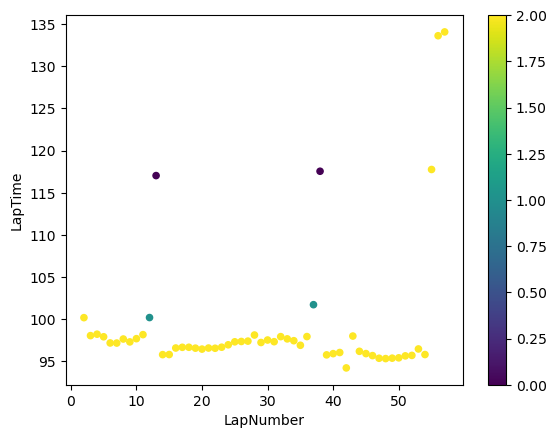

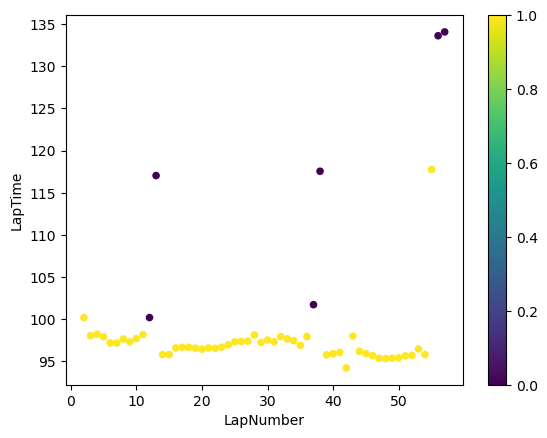

In [10]:
b2.plot(x='LapNumber', y='LapTime', kind='scatter', colormap='viridis', c=b2['PitStatus'].map({'OutLap': 0, 'InLap': 1, 'NoPit': 2}))
b2.plot(x='LapNumber', y='LapTime', kind='scatter', colormap='viridis', c=b2['IsAccurate'])

In [21]:
b['PitOutTime']

57        7.776
58          NaT
59          NaT
60          NaT
61          NaT
62          NaT
63          NaT
64          NaT
65          NaT
66          NaT
67          NaT
68          NaT
69       3213.3
70          NaT
71          NaT
72          NaT
73          NaT
74          NaT
75          NaT
76          NaT
77          NaT
78          NaT
79          NaT
80          NaT
81          NaT
82          NaT
83          NaT
84          NaT
85          NaT
86          NaT
87          NaT
88          NaT
89          NaT
90          NaT
91          NaT
92          NaT
93          NaT
94     5662.851
95          NaT
96          NaT
97          NaT
98          NaT
99          NaT
100         NaT
101         NaT
102         NaT
103         NaT
104         NaT
105         NaT
106         NaT
107         NaT
108         NaT
109         NaT
110         NaT
111         NaT
112         NaT
113         NaT
Name: PitOutTime, dtype: object